In [ ]:
import os
import sys
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import einops
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

if "x-perceiver" not in os.listdir():
    os.chdir("/Users/konsti/Documents/repos/phd/x-perceiver/")

%reload_ext autoreload
%autoreload 2

In [2]:
import einops
from torch.utils.data import Dataset
from torchvision import transforms
from x_perceiver.utils import Config
from openslide import OpenSlide
import os
import torch
import pprint
from functools import partial
from einops import rearrange, repeat
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from typing import *
from box import Box

In [3]:
from x_perceiver.utils import Config
from x_perceiver.etl import TCGADataset
from x_perceiver.train import train_loop

### Load data

In [4]:
# Molecular data
config = Config("config/main.yml").read()
blca = TCGADataset("blca", config, filter_omic=False)

Dataset: BLCA
Molecular data shape: (437, 2191)
Total slides available: 3
Molecular/Slide match: 3/437
Slide level count: 4
Slide level dimensions: ((97608, 86281), (24402, 21570), (6100, 5392), (3050, 2696))
Slide resize dimensions: w: 3072, h: 2688
Sources selected: ['omic', 'slides']
Censored share: 0.54


In [5]:
blca.omic_df.shape

(437, 2191)

In [12]:
slide_path.joinpath(slide_name)

PosixPath('data/tcga/wsi/blca/TCGA-CF-A9FM-01Z-00-DX1.F9379708-8E04-435E-BF12-8E3222AE728D.svs')

In [18]:
data_path = Path("data/tcga/wsi/blca")
slide_path = list(blca.wsi_paths.values())[0]
slide= OpenSlide(slide_path)

In [48]:
slide.level_downsamples

(1.0, 4.000050202483349, 16.00202282621025, 32.00618839589947)

## Feature channels

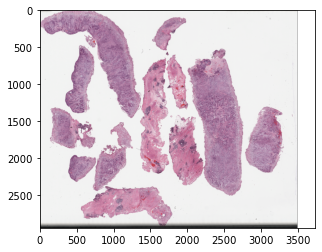

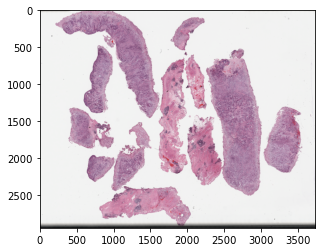

In [63]:
# whole image
level=3
downsampling = int(slide.level_downsamples[level])

size = slide.level_dimensions[level]
region1 = slide.read_region((250*downsampling,0*downsampling), level, size)
region2 = slide.read_region((0*downsampling,0*downsampling), level, size)
plt.imshow(region1)
plt.show()
plt.imshow(region2)
plt.show()

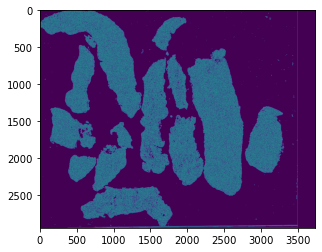

In [67]:
import cv2

def extract_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return edges

edges = extract_edges(np.array(region1))
plt.imshow(edges)
plt.show()

In [56]:
# in patches
patch_height = 256 # patch size in pixels
patch_width = 256
level = 3
sampling_factor = int(slide.level_downsamples[level]) # need to use sampling factor to get correct coordinates (read_region uses level 0 coordinates)

(img_width, img_height) = slide.level_dimensions[level]
num_patches_h = int(img_height / patch_height)
num_patches_w = int(img_width / patch_width)
num_patches = num_patches_h * num_patches_w

# patch_dict = {}

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]), # remove alpha channel
    # RearrangeTransform("c h w -> h w c")
])


for h in range(num_patches_h):
    for w in range(num_patches_w, 5):
        y = h * patch_height * sampling_factor
        x = w * patch_width * sampling_factor
        print(x,y)
        patch = slide.read_region(location=(x,y), level=level, size=(patch_height, patch_width))
        patch_tensor = transforms.ToTensor()(patch)


# size = (patch_height, patch_width)
# size = slide.level_dimensions[level]
# read in patches as grid
# patch_grid = []

# region = slide.read_region((0,0), level, size)
# show region read in
# plt.imshow(region)

In [61]:
edges = extract_edges(np.array(patch))

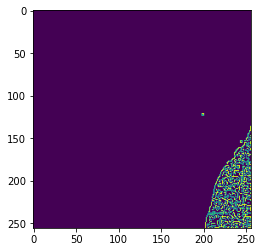

In [62]:
plt.imshow(edges)
plt.show()

In [ ]:


def load_wsi_patches(slide_id):
    pass
    # wsi_paths = blca.wsi_paths
    # wsi_ids = blca.wsi_ids
    # wsi_patches = []
    # for wsi_id in wsi_ids:
    #     wsi_path = wsi_paths[wsi_id]
    #     wsi = OpenSlide(wsi_path)
    #     wsi_patches.append(wsi)
    # return wsi_patches

# def load_wsi():
#         slide_path = wsi_paths[slide_id]
#         slide = OpenSlide(slide_path)
#
#         # specify resolution level
#         if resolution is None and level is None:
#             raise ValueError("Must specify either resolution or level")
#         elif resolution is not None:
#             valid_resolutions = ["lowest", "mid", "highest"]
#             assert resolution in valid_resolutions, f"Invalid resolution arg, must be one of {valid_resolutions}"
#             if resolution == "lowest":
#                 level = slide.level_count - 1
#             if resolution == "highest":
#                 level = 0
#             if resolution == "mid":
#                 level = int(slide.level_count / 2)
#         if level > slide.level_count - 1:
#             level = slide.level_count - 1
#         # load in region
#         size = slide.level_dimensions[level]
#         region = slide.read_region((0,0), level, size)
#         # print(f"Transforming image {slide_id}")
#         transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Lambda(lambda x: x[:3, :, :]), # remove alpha channel
#             transforms.Resize((self.wsi_height, self.wsi_width)),
#             RearrangeTransform("c h w -> h w c")
#         ])
#         region_tensor = transform(region)
#         # cast as float16
#         # region_tensor = region_tensor.to(dtype=torch.float16)
#
#         return slide, region_tensor

### Load CLAM patches

In [42]:
# level=3

In [43]:
# take sample slide
# os.listdir(prep_path.joinpath("patches"))

['TCGA-CF-A9FM-01Z-00-DX1.F9379708-8E04-435E-BF12-8E3222AE728D.h5',
 'TCGA-XF-AAMH-01Z-00-DX1.AB5E1C7D-C3BF-4A69-B614-0ED69F8A3C07.h5',
 'TCGA-YC-A89H-01Z-00-DX1.ACE5AFD4-274B-4579-9B0E-EDD8D9251A8C.h5']

In [44]:
# load in patches
import h5py

# patch_path = prep_path.joinpath(f"patches/{slide_id}.h5")
# h5_file = h5py.File(patch_path, "r")
# with h5py.File(patch_path, "r") as f:
#     patches = f["patches"][:]

In [104]:
def load_patch_coords():
    """
    Loads all patch coordinates for the dataset and level specified in the config
    """
    dataset = "blca"
    prep_path = Path(config.tcga_path).joinpath(f"wsi/{dataset}_preprocessed_level{level}")
    raw_path = Path(config.tcga_path).joinpath(f"wsi/{dataset}")
    slide_ids = [slide_id.rsplit(".", 1)[0] for slide_id in os.listdir(prep_path.joinpath("patches"))]
    coords = {}
    for slide_id in slide_ids:
        patch_path = prep_path.joinpath(f"patches/{slide_id}.h5")
        h5_file = h5py.File(patch_path, "r")
        patch_coords = h5_file["coords"][:] # gives x,y coordinates of regions to read in
        coords[slide_id] = patch_coords
    return coords

coords = load_patch_coords()


In [139]:
from torchvision import transforms
# patch_coords = h5_file["coords"][:] # gives x,y coordinates of regions to read in

def load_patches(slide_id: str, level: int = 2):
    coords = load_patch_coords() # dictionary of all slide patch coordinates
    num_patches = [len(coord) for coord in coords.values()]
    patch_tensors = torch.zeros(max(num_patches), 3, 256, 256)
    print(max(num_patches))
    for idx, coord in enumerate(coords[slide_id]):
        x, y = coord
        slide = OpenSlide(raw_path.joinpath(f"{slide_id}.svs"))
        patch = slide.read_region(location=(x,y), level=level, size=(256, 256))
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3, :, :]), # remove alpha channel
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        patch_tensor = transform(patch)
        patch_tensors[idx] = patch_tensor
    return patch_tensors


dataset = "blca"
prep_path = Path(config.tcga_path).joinpath(f"wsi/{dataset}_preprocessed_level{level}")
raw_path = Path(config.tcga_path).joinpath(f"wsi/{dataset}")
slide_id1 = os.listdir(raw_path)[0].rsplit(".", 1)[0] # (split to remove .svs)
slide_id2 = os.listdir(raw_path)[1].rsplit(".", 1)[0]

patch_tensor1 = load_patches(slide_id1, level=2)
patch_tensor2 = load_patches(slide_id2, level=2)


97
97


In [140]:
print(patch_tensor1.shape)

torch.Size([97, 3, 256, 256])


In [119]:
pca = torch.pca_lowrank(patch_tensor1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


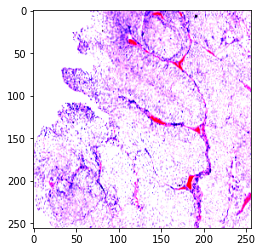

In [143]:
patch_tmp = patch_tensor1[1].permute(1,2,0)
plt.imshow(patch_tmp)
plt.show()

In [121]:
num_components = 10
selected_components = pca.eigenvectors()[:, :num_components]

AttributeError: 'tuple' object has no attribute 'eigenvectors'

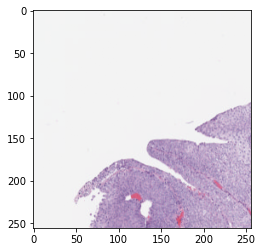

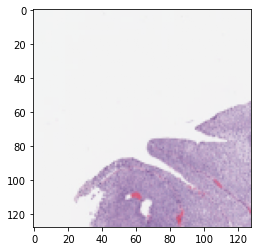

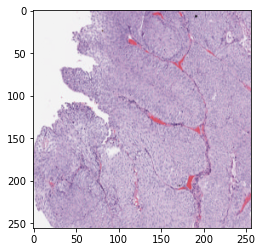

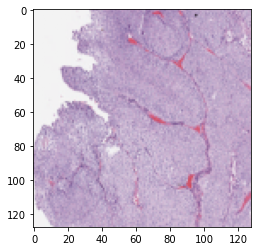

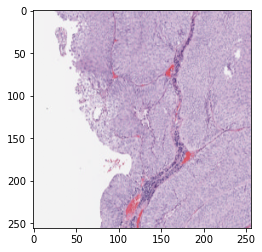

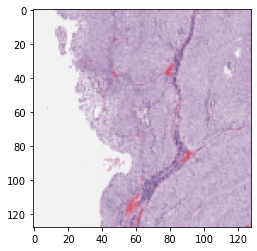

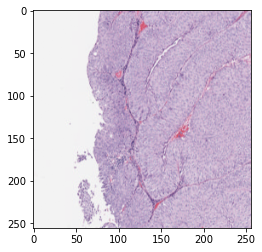

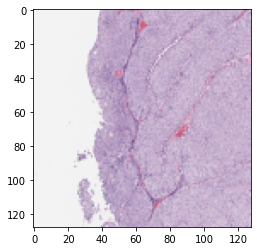

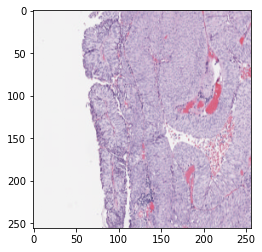

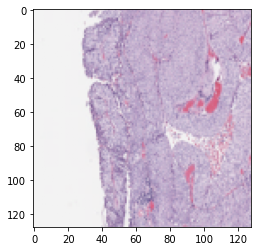

In [70]:
# for tensor in patch_tensor1[:5]:
#     tensor_resized = transforms.Resize((128, 128))(tensor)
#     plt.imshow(tensor.permute(1,2,0))
#     plt.show()
#     plt.imshow(tensor_resized.permute(1,2,0))
#     plt.show()

In [65]:
# print(patch_tensor1.shape)
# print(patch_tensor2.shape)

torch.Size([325, 4, 256, 256])
torch.Size([309, 4, 256, 256])


In [60]:
# # shape: p c h w (patches, channels, height, width)
# patch_tensors = torch.zeros((len(patches), 4, 256, 256))
# for idx, patch in enumerate(patches):
#     # convert to tensor
#     patch_tensor = transforms.ToTensor()(patch)
#     patch_tensors[idx] = patch_tensor
#


In [59]:
patch_tensor.shape

torch.Size([4, 256, 256])

In [56]:
patch_tensors.shape

AttributeError: 'list' object has no attribute 'shape'

In [132]:
# slide = OpenSlide(raw_path.joinpath(f"{slide_id}.svs"))
sample_patch = patches[0]



In [134]:
# encode each patch as 1024 dimensional vector with ResNet
import torchvision.models as models

encoder_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

encoder_model.eval()





Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/konsti/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


In [40]:
patch_coords

array([[ 3360, 59648],
       [ 3360, 59904],
       [ 3360, 60160],
       ...,
       [89120, 71424],
       [89120, 71680],
       [89120, 71936]])

In [31]:
# import cv2
# mask_path = prep_path.joinpath(f"masks/{slide_id}.png")
# read in png file and show in matplotlib
